# Learning Special Patterns

Here we examine how a modestly deep network of dense layers is able to recognize the fact that one feature influences how the target label depends on another feature. Our dataset will have the following characteristic: A label has an affine dependency on variable x_lin. But the coefficients of that dependency depend themselves on variable x_ind. Indeed, they are constant within certain ranges of x_ind. x_ind obviously represents a hidden variable that has the power to switch certain dynamics on and off. Frequencies (e.g. of machine parts) are candidates for such features that may have this characteristic when they approach eigen-frequencies of the system. Time features like hour of day or any other may expose similar characteristics when unwisely modelled as numerical features.

In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#### Guaranteeing reproducible results

Guaranteeing reproducible results by seeding all random number generators. Thanks for the enlightening advice, [Aurelion Geron](https://www.youtube.com/watch?v=Ys8ofBeR2kA)

In [3]:
def seed_random(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)

Make sure you started this notebook with ```PYTHONHASHSEED=0 <your_jupyter_cmd>```: 

In [4]:
import os
os.getenv('PYTHONHASHSEED')

'0'

In [5]:
seed_random(40)

---
#### An *indicator* function
We use this indicator function to model *dramatic* changing behaviour in variable ```x_ind```

In [6]:
def rangind(bl, br):
    def _f(x):
        return (np.sign(x-bl+.01)+1) * (np.sign(br - x+.01)+1)/4.0
    return _f

In [7]:
indicator = lambda x: rangind(-.5, -.2)(x) + rangind(.2,.5)(x)
#fn = lambda x: rangind(-1, 0)(x)

Our indicator function indicates that its x value is within a certain range, or set of ranges

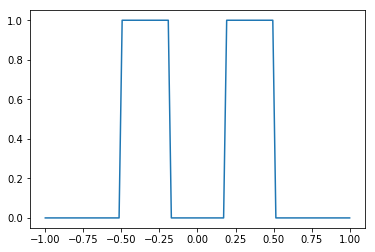

In [8]:
x= np.linspace(-1, 1, 100)
plt.plot(x,indicator(x));

#### Two input features with dramatically different characteristics

In [9]:
def fn2(x_ind, x_affine):
    a0, a1, b0, b1 = .5, -1.0, -0.4, 0.3
    ind = indicator(x_ind)
    a = a0 * ind + a1 * (1 - ind)
    b = b0 * ind + b1 * (1 - ind)
    return a * x_affine + b

Different affine functions in ```x_affine``` for different values of ```x_ind```

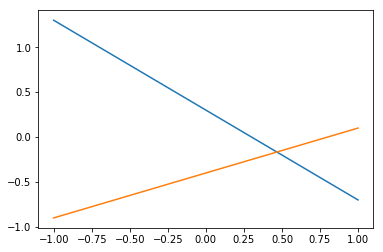

In [10]:
plt.plot(x, fn2(x_ind=0.0, x_affine=x))
plt.plot(x, fn2(x_ind=0.3, x_affine=x));

In [11]:
from mpl_toolkits import mplot3d

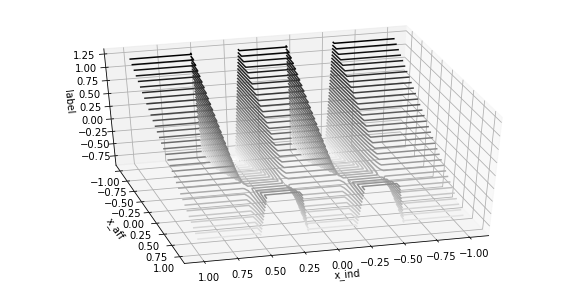

In [44]:
x = np.linspace(-1, 1, 40)
y = np.linspace(-1, 1, 40)

X, Y = np.meshgrid(x, y)
Z = fn2(X, Y)
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 40, cmap='binary')
ax.set_xlabel('x_ind')
ax.set_ylabel('x_aff')
ax.set_zlabel('label')
ax.view_init(40, 75)

Now, that's a pretty weird function, isn't it? It's basically a 'mixture' of two function that are affine in x_lin, but with different coefficients. For some values of x_ind, the first function appears. For others, the second function shows up. The question is: Can we find a neural network architecture that's able to efficiently learn such a function?

---
#### Learning arbitrary functions in one dimension 
Let's first observe how a very small deep-ish neural network can learn to model the indicator function.

In [13]:
noisy=lambda x: x+ np.random.normal(loc=0.0, scale=.02, size=len(x))

In [14]:
def create_1D_data_frame(function, left, right, size, noisy=None):
    import numpy as np
    import pandas as pd

    if noisy == None:
        noisy = lambda x: x
    x_data = np.random.uniform(low=left, high=right, size=size)
    y_data = noisy(function(x_data))
    return pd.DataFrame({'x': x_data, 'y': y_data})

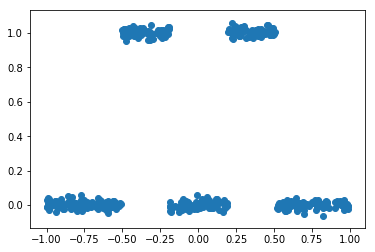

In [15]:
df = create_1D_data_frame(indicator, -1, 1, 400, noisy)
x_input = list(df['x'])
x_input = np.reshape(x_input, (-1, 1)) # cosmetics for the neural network
y_input = list(df['y'])
y_input = np.reshape(y_input, (-1, 1)) # cosmetics for the neural network
plt.scatter(list(df['x']),list(df['y']));

The feature $x$ on the x-Axis has an influence on the to-be-predicted observable $y$ only if it is between -0.2 and -0.5 or between 0.2 and 0.5  

In [16]:
x_p=tf.placeholder(shape=(None, 1), dtype=tf.float32)
y_p=tf.placeholder(shape=(None, 1), dtype=tf.float32)

In [17]:
lrelu = lambda x: tf.nn.leaky_relu(alpha=.02, features=x)

In case you wonder: I'm using ```leaky_relu``` here, because ```relu```s can easily starve off once in the negative reign. For large models, that's typically not a problem but in fact desired. In small models though, too often all gradients disappear and training doesn't go anywhere. 

In [18]:
def dnn(units, inp):
    _inp = inp
    for u in units:
        l = tf.layers.Dense(units=u, activation=lrelu)
        _inp = l(_inp)
    return _inp

In [19]:
h = dnn([4,4,4,1], x_p)

The following cell is again to guarantee reproducibility

In [20]:
config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

In [21]:
init = tf.global_variables_initializer()

In [22]:
loss=tf.losses.mean_squared_error(y_p, h)

In [23]:
optimizer=tf.train.GradientDescentOptimizer(learning_rate=.1)
train_op = optimizer.minimize(loss=loss)

0.019551212


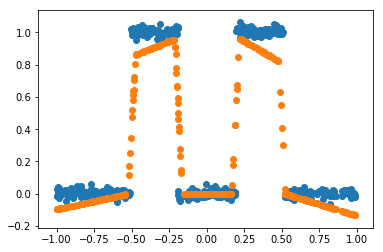

In [24]:
with tf.Session(config=config) as sess:
    sess.run(init)
    for _ in range(10000):
        _, loss_r = sess.run([train_op, loss], feed_dict={x_p: x_input, y_p: y_input})

    y, y_ = sess.run([h, y_p], feed_dict={x_p: x_input, y_p: y_input})


print(loss_r)

y=[l[0] for l in list(y)]
y_=[l[0] for l in list(y_)]

plt.scatter(x_input, y_)
plt.scatter(x_input, y)

Our simple neural network is able to learn the indicator function. But what, if this indicator function is in fact not known? What, if we only know this function ```fn2``` from measurements of ```x_affine``` and ```x_lin```?

---
#### The training data set

In [49]:
def create_2D_data_frame(function, r1, r2, size, noisy=None):
    import numpy as np
    import pandas as pd

    if noisy == None:
        noisy = lambda x: x
    x_data = np.random.uniform(low=r1[0], high=r1[1], size=size)
    y_data = np.random.uniform(low=r2[0], high=r2[1], size=size)
    z_data = noisy(function(x_data, y_data))
    return pd.DataFrame({'x': x_data, 'y': y_data, 'label': z_data})

In [50]:
data = create_2D_data_frame(fn2, [-1, 1], [-1, 1], 1000, noisy=noisy)

In [51]:
data.head()

,label,x,y
0,0.703386,0.565255,-0.383664
1,-0.745620,-0.236389,-0.691674
2,0.326793,-0.791262,-0.036039
3,0.883307,0.140798,-0.588837
4,-0.255922,-0.370611,0.271435


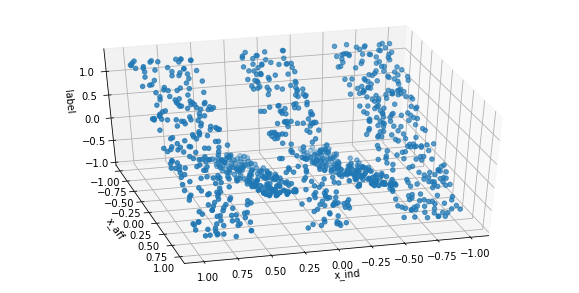

In [52]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.scatter(data['x'], data['y'], data['label'], '.', cmap='binary')
ax.set_xlabel('x_ind')
ax.set_ylabel('x_aff')
ax.set_zlabel('label');
ax.view_init(40, 75)

In [53]:
x_input = zip(list(data['x']), list(data['y']))
x_input = np.reshape(x_input, (-1, 2)) # cosmetics for the neural network
y_input = list(data['label'])
y_input = np.reshape(y_input, (-1, 1)) # cosmetics for the neural network

In [54]:
x_p=tf.placeholder(shape=(None, 2), dtype=tf.float32)
y_p=tf.placeholder(shape=(None, 1), dtype=tf.float32)
h = dnn([4,8,8,4, 1], x_p)

In [55]:
init = tf.global_variables_initializer()
loss=tf.losses.mean_squared_error(y_p, h)
optimizer=tf.train.GradientDescentOptimizer(learning_rate=.05)
train_op = optimizer.minimize(loss=loss)

In [56]:
xm = np.linspace(-1, 1, 100)
ym = np.linspace(-1, 1, 100)
Xm, Ym = np.meshgrid(xm, ym)
mesh_input=np.reshape(zip(Xm,Ym), (-1, 2))

In [57]:
N= 80000
with tf.Session(config=config) as sess:
    sess.run(init)
    for i in range(N):
        _, loss_r = sess.run([train_op, loss], feed_dict={x_p: x_input, y_p: y_input})
        if i % 4000 == 0:
            print(loss_r)
    x, y, y_ = sess.run([x_p, h, y_p], feed_dict={x_p: x_input, y_p: y_input})
    zm = sess.run([h], feed_dict={x_p: mesh_input})


0.36790287
0.12487828
0.10389961
0.11216108
0.05004361
0.04103587
0.034496874
0.029454261
0.026147224
0.025050858
0.035675477
0.01863886
0.017889231
0.017203255
0.021022514
0.015862497
0.014738192
0.022295374
0.015853513
0.028921044


The loss should go down well below $0.03$. If not, just run the above cell again. Sometimes the algorithm gets stuck in a local minimum. 

In [62]:
xv = x[:,0]
yv = x[:,1]
zv = y

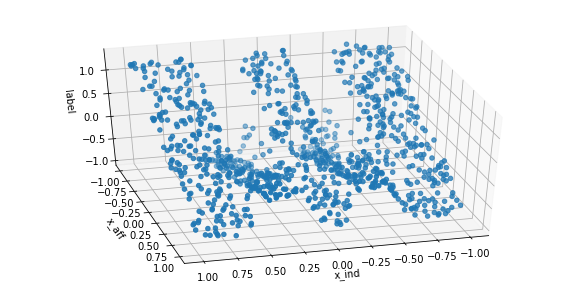

In [63]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.scatter(xv, yv, zv, '.', cmap='binary')
ax.set_xlabel('x_ind')
ax.set_ylabel('x_aff')
ax.set_zlabel('label');
ax.view_init(40, 75)

This is not so convincing, is it? But now let's see whether we can do even better by adding a grain of heuristic into the architecture. Let's assume we know that somehow one of the features impacts the linear influence of the other feature in some almost categorical manner. We express that heuristic knowledge by taking two linear estimators in ```x_aff``` and letting a 1-dim classifier learn to switch between them, depending on the value of ```x_ind```.

---
#### A heuristically motivated architecture

In [74]:
x_aff = list(data['y'])
x_ind = list(data['x'])
x_aff_input = np.reshape(x_aff, (-1, 1)) # cosmetics for the neural network
x_ind_input = np.reshape(x_ind, (-1, 1))
y_input = list(data['label'])
y_input = np.reshape(y_input, (-1, 1))

In [76]:
xp_aff=tf.placeholder(shape=(None, 1), dtype=tf.float32)
xp_ind=tf.placeholder(shape=(None, 1), dtype=tf.float32)
y_p=tf.placeholder(shape=(None, 1), dtype=tf.float32)

# The suspected indicator has its own 'private' neural network.
# This network has a sigmoid activation and will learn to 'switch' 
z0 = dnn([4,4,4], xp_ind)
z0 = tf.layers.Dense(units=1, activation='sigmoid')(z0)

# Two identical linear regressors
z1 = tf.layers.Dense(units=1, activation=None)(xp_aff)
z2 = tf.layers.Dense(units=1, activation=None)(xp_aff)

# Being switched by the indicator's activation function
h = z0*z1 + (1-z0)*z2

![Heuristic Architecture](./Heuristic_Architecture.png)
This sketch illustrates the computational graph that we're about to train.

In [77]:
init = tf.global_variables_initializer()
loss=tf.losses.mean_squared_error(y_p, h)
optimizer=tf.train.GradientDescentOptimizer(learning_rate=.05)
train_op = optimizer.minimize(loss=loss)

In [78]:
N= 40000
with tf.Session(config=config) as sess:
    sess.run(init)
    for i in range(N):
        _, loss_r = sess.run([train_op, loss], feed_dict={xp_aff: x_aff_input, xp_ind: x_ind_input, y_p: y_input})
        if i % 4000 == 0:
            print(loss_r)
    xi, xa, y = sess.run([xp_ind, xp_aff, h], feed_dict={xp_aff: x_aff_input, xp_ind: x_ind_input})


0.29229522
0.2547706
0.2545826
0.24724606
0.04527973
0.0312628
0.017794318
0.022617644
0.01857368
0.015812146


In [79]:
xv = xi
yv = xa
zv = y

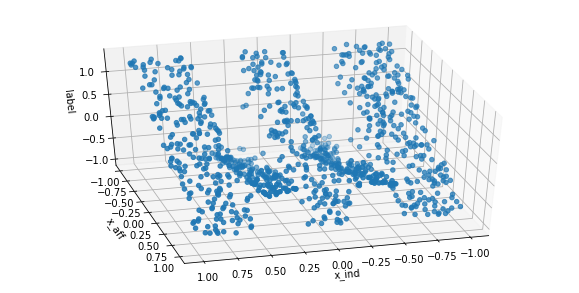

In [80]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')
ax.scatter(xv, yv, zv, '.', cmap='binary')
ax.set_xlabel('x_ind')
ax.set_ylabel('x_aff')
ax.set_zlabel('label');
ax.view_init(40, 75)

Observe how much faster our new model learns the parameters!